# Introduction

Many purchases nowadays is done with loaned money, because it is hard for people and business to save the needed money amount for big purchases. By getting a loan people and business promise to pay back that money by contract, but bank can approve or reject loan. I was hired to analyse bank loan data and automate their lending decisions fully.
In the first meeting with your team, you all have decided to use this dataset. In addition, you have decided to tackle this problem iteratively so that you can get test your hypothesis that you can automate these decisions and get actual feedback from the users as soon as possible. For that, you have proposed a three-step plan on how to approach this problem.

**Analyses plan**
- The first step of your plan is to create a machine learning model to classify loans into accepted/rejected so that you can start learning if you have enough data to solve this simple problem adequately.

- The second step is to predict the grade for the loan
- The third step is to predict the subgrade and the interest rate. 



# Data preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score, precision_score,recall_score, mean_squared_error, roc_auc_score
from sklearn.metrics import  confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
import statsmodels.api as sm
from itertools import combinations
from scipy.stats import pearsonr, chi2_contingency
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import sklearn.metrics as metrics
import matplotlib.patches as  mpatches


In [3]:
df = pd.read_csv("../input/lendingclub/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv", parse_dates=['issue_d'], infer_datetime_format=True)
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df.head())

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,2015-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,2015-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,N

Taking the newest data from 2018

In [4]:
df = df[(df.issue_d >= '2018-01-01 00:00:00') ]
df = df.sample(n=200000)

Take rejected data and filter by date

In [5]:
df_rejected = pd.read_csv("/kaggle/input/lendingclub2/rejected_2007_to_2018Q4.csv", parse_dates=['Application Date'], infer_datetime_format=True)
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df_rejected.head())

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0.0


In [6]:
df_rejected = df_rejected[(df_rejected['Application Date'] >= '2018-01-01') ]
df_rejected = df_rejected.sample(n=200000)

# EDA

To compare 2 datasets accepted and rejected we need to have the same columns.

In [7]:
approved_columns= ['loan_amnt', 'issue_d', 'title', 'fico_range_low', 'dti', 'zip_code', 'addr_state', 'emp_length', 'policy_code']

In [8]:
df_approved = df[approved_columns]
df_approved.head()

,loan_amnt,issue_d,title,fico_range_low,dti,zip_code,addr_state,emp_length,policy_code
824462,30000.0,2018-08-01,Debt consolidation,705.0,4.55,334xx,FL,1 year,1.0
1591201,24000.0,2018-04-01,Home improvement,720.0,10.28,211xx,MD,4 years,1.0
503256,2000.0,2018-01-01,Other,660.0,21.36,327xx,FL,< 1 year,1.0
1492089,15000.0,2018-06-01,Home improvement,675.0,20.72,322xx,FL,10+ years,1.0
461209,20000.0,2018-02-01,Debt consolidation,740.0,14.41,082xx,NJ,3 years,1.0


In [9]:
df_rejected = df_rejected.rename(columns={'Amount Requested':'loan_amnt', 'Application Date':'issue_d', 'Loan Title':'title', 'Risk_Score':'fico_range_low',
       'Debt-To-Income Ratio':'dti', 'Zip Code': 'zip_code', 'State':'addr_state', 'Employment Length':'emp_length',
       'Policy Code':'policy_code'})
df_rejected.dti = df_rejected.dti.str.rstrip('%').astype(np.float64)

## Find the outliers

Check the outliers of both datasets

In [10]:
df_numbers = df_approved.select_dtypes(np.number)
Q1 = df_numbers.quantile(0.25)
Q3 = df_numbers.quantile(0.75)
IQR = Q3 - Q1

outliers_approved = (df_numbers < (Q1 - 1.5 * IQR)) | (df_numbers > (Q3 + 1.5 * IQR))
print("Approved:")
((df_numbers < (Q1 - 1.5 * IQR)) | (df_numbers > (Q3 + 1.5 * IQR))).sum()

Approved:


loan_amnt            0
fico_range_low    5525
dti               4347
policy_code          0
dtype: int64

In [11]:
df_numbers = df_rejected.select_dtypes(np.number)
Q1 = df_numbers.quantile(0.25)
Q3 = df_numbers.quantile(0.75)
IQR = Q3 - Q1

outliers_rejected = (df_numbers < (Q1 - 1.5 * IQR)) | (df_numbers > (Q3 + 1.5 * IQR))
print("Rejected:")
((df_numbers < (Q1 - 1.5 * IQR)) | (df_numbers > (Q3 + 1.5 * IQR))).sum()

Rejected:


loan_amnt           742
fico_range_low      209
dti               26983
policy_code         870
dtype: int64

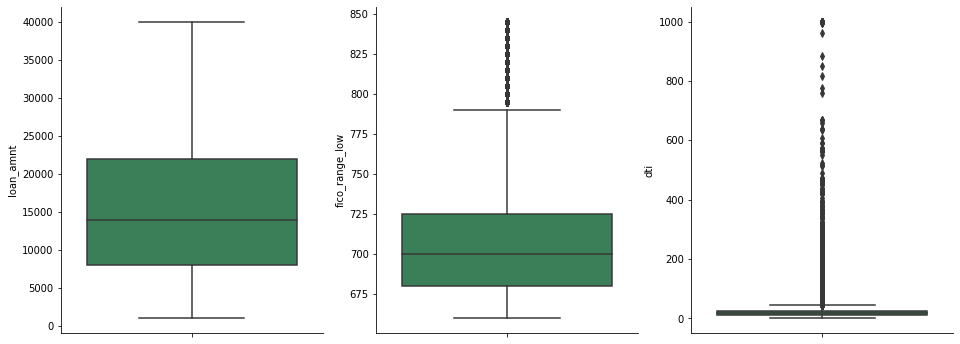

In [12]:
fig, ax1= plt.subplots(1,3,figsize=(16,6))
plt.rc("font", size=12)

sns.boxplot(y=df_approved["loan_amnt"], color="seagreen", ax=ax1[0])
sns.boxplot(y=df_approved["fico_range_low"], color="seagreen", ax=ax1[1])
sns.boxplot(y=df_approved["dti"], color="seagreen", ax=ax1[2])

sns.despine()
plt.show()

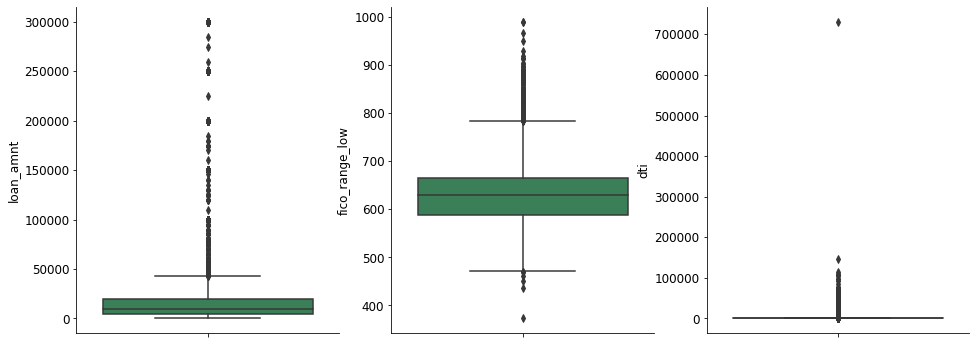

In [13]:
fig, ax1= plt.subplots(1,3,figsize=(16,6))
plt.rc("font", size=12)

sns.boxplot(y=df_rejected["loan_amnt"], color="seagreen", ax=ax1[0])
sns.boxplot(y=df_rejected["fico_range_low"], color="seagreen", ax=ax1[1])
sns.boxplot(y=df_rejected["dti"], color="seagreen", ax=ax1[2])

sns.despine()
plt.show()

In [14]:
df_approved = df_approved[(outliers_approved.loan_amnt == False) & (outliers_approved.fico_range_low == False) & (outliers_approved.dti == False) ]
df_rejected = df_rejected[(outliers_rejected.loan_amnt == False) & (outliers_rejected.fico_range_low == False) & (outliers_rejected.dti == False) ]

Let's look at empty values

Printing mean null values in the column

In [16]:
nan_mean = df_approved.isna().mean()
nan_mean = nan_mean[nan_mean != 0].sort_values()
nan_mean.tail()

dti           0.002266
emp_length    0.079758
dtype: float64

In [17]:
nan_mean = df_rejected.isna().mean()
nan_mean = nan_mean[nan_mean != 0].sort_values()
nan_mean.tail()

emp_length        0.031993
fico_range_low    0.928056
dtype: float64

In approved dataset we can simply drop null values and have enough data, but for rejected dataset we need to fill fico_range_low column to have enough data.

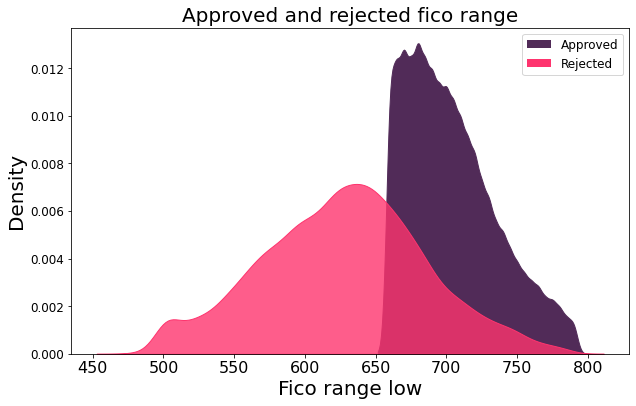

In [18]:
import matplotlib.patches as  mpatches

plt.figure(figsize = (10,6))
ax = sns.kdeplot(data = df_approved, x = 'fico_range_low', shade = True,  alpha = 1, color = '#512b58' )
ax = sns.kdeplot(data = df_rejected, x = 'fico_range_low',shade = True,  alpha = 0.8, color = '#fe346e')

plt.xticks(fontsize=16)
ax.set_xlabel("Fico range low", fontsize = 20)
ax.set_ylabel("Density", fontsize = 20)
ax.set_title("Approved and rejected fico range", fontsize = 20)
handles = [mpatches.Patch(facecolor='#512b58', label="Approved"),
           mpatches.Patch(facecolor='#fe346e', label="Rejected")]
plt.legend(handles=handles)
plt.show()

In the graph we see that rejected Fico range peak is about 625 and it is a visible difference between approved Fico range so fill the empty Fico range valus with median value.

In [18]:
median = df_rejected.fico_range_low.median()
df_rejected.fico_range_low = df_rejected.fico_range_low.fillna(median)


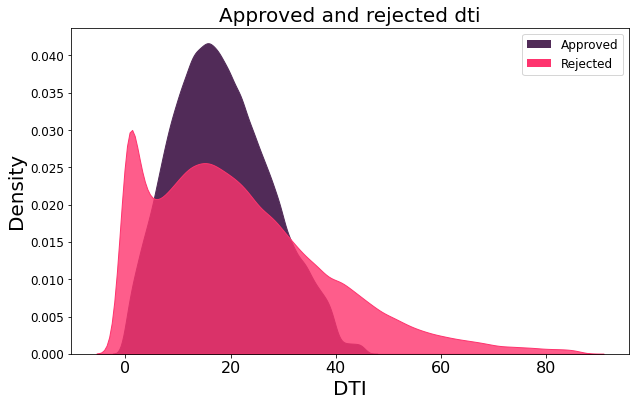

In [20]:
plt.figure(figsize = (10,6))
ax = sns.kdeplot(data = df_approved, x = 'dti', shade = True,  alpha = 1, color = '#512b58' )
ax = sns.kdeplot(data = df_rejected, x = 'dti',shade = True,  alpha = 0.8, color = '#fe346e')

plt.xticks(fontsize=16)
ax.set_xlabel("DTI", fontsize = 20)
ax.set_ylabel("Density", fontsize = 20)
ax.set_title("Approved and rejected dti", fontsize = 20)
handles = [mpatches.Patch(facecolor='#512b58', label="Approved"),
           mpatches.Patch(facecolor='#fe346e', label="Rejected")]
plt.legend(handles=handles)
plt.show()

It's time do delete null values and make smaller sample of each dataset at 100k rows

In [19]:
df_approved = df_approved.dropna()
df_rejected = df_rejected.dropna()
df_approved = df_approved.sample(n=100000)
df_rejected = df_rejected.sample(n=100000)

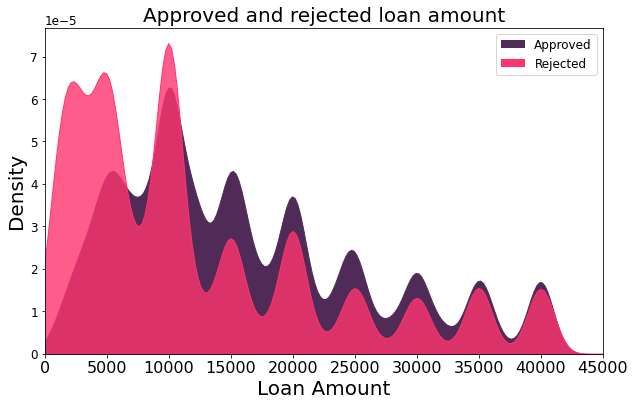

In [22]:
plt.figure(figsize = (10,6))
ax = sns.kdeplot(data = df_approved, x = 'loan_amnt', shade = True,  alpha = 1, color = '#512b58' )
ax = sns.kdeplot(data = df_rejected, x = 'loan_amnt',shade = True,  alpha = 0.8, color = '#fe346e')

plt.xticks(fontsize=16)
ax.set_xlabel("Loan Amount", fontsize = 20)
ax.set_ylabel("Density", fontsize = 20)
ax.set_title("Approved and rejected loan amount", fontsize = 20)
handles = [mpatches.Patch(facecolor='#512b58', label="Approved"),
           mpatches.Patch(facecolor='#fe346e', label="Rejected")]
plt.legend(handles=handles)
plt.xlim(0,45000)
plt.show()

From the graph we see that quite similar amounts were approved and rejected.

In [21]:
df_approved['emp_length'].value_counts()

10+ years    35117
2 years       9965
< 1 year      9673
3 years       8976
1 year        7460
4 years       6906
5 years       6828
6 years       4840
7 years       3913
8 years       3536
9 years       2786
Name: emp_length, dtype: int64

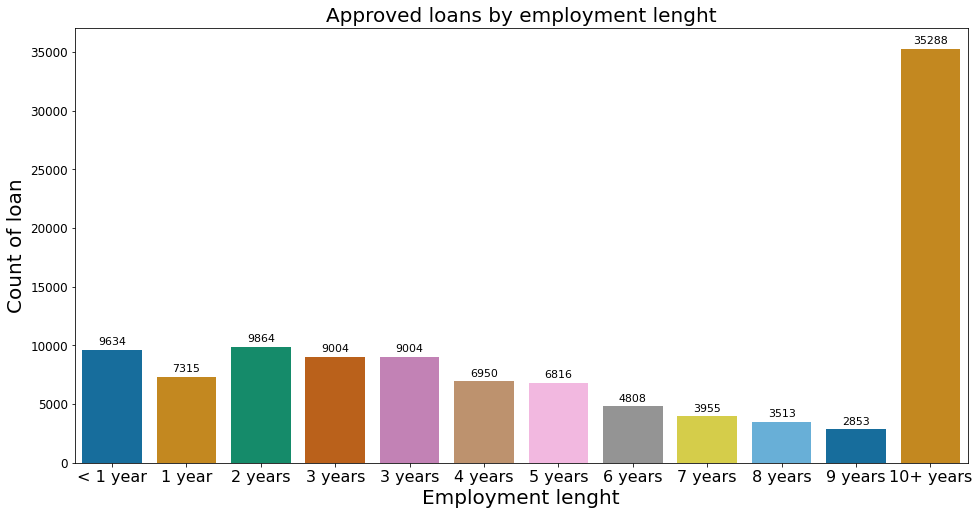

In [24]:

fig = plt.figure(figsize = (16,8))
ax = sns.countplot(data = df_approved, x='emp_length', palette='colorblind',
                   order = ['< 1 year', '1 year', '2 years', '3 years','3 years','4 years','5 years','6 years','7 years','8 years','9 years','10+ years' ],)
for bar in ax.patches:
    ax.annotate(format(bar.get_height()),
        (bar.get_x() + bar.get_width() / 2,
        bar.get_height()), ha='center', va='center',
        size=11, xytext=(0, 8),
        textcoords='offset points')
plt.xticks(fontsize=16)
ax.set_xlabel("Employment lenght", fontsize = 20)
ax.set_ylabel("Count of loan", fontsize = 20)
ax.set_title("Approved loans by employment lenght", fontsize = 20)
plt.show()

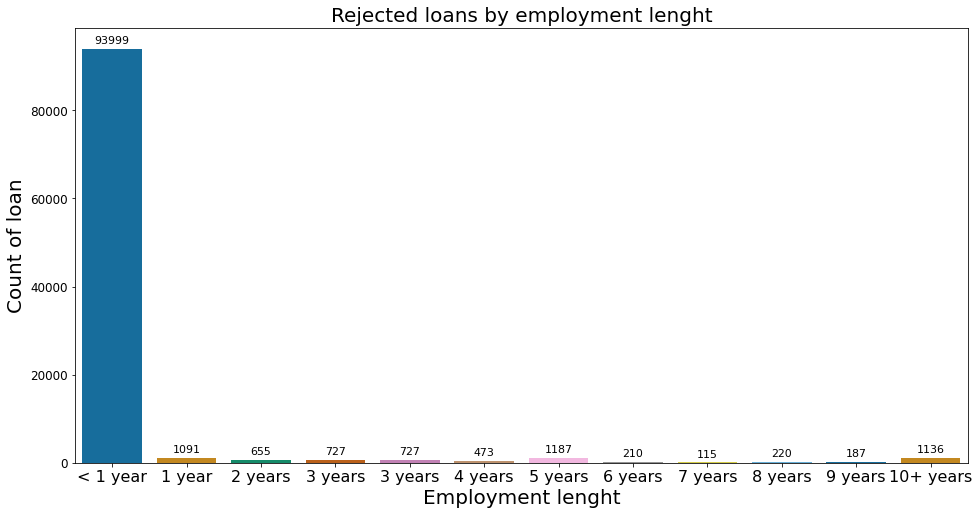

In [25]:
fig = plt.figure(figsize = (16,8))
ax = sns.countplot(data = df_rejected, x='emp_length', palette='colorblind',
                   order = ['< 1 year', '1 year', '2 years', '3 years','3 years','4 years','5 years','6 years','7 years','8 years','9 years','10+ years' ],)
for bar in ax.patches:
    ax.annotate(format(bar.get_height()),
        (bar.get_x() + bar.get_width() / 2,
        bar.get_height()), ha='center', va='center',
        size=11, xytext=(0, 8),
        textcoords='offset points')
plt.xticks(fontsize=16)
ax.set_xlabel("Employment lenght", fontsize = 20)
ax.set_ylabel("Count of loan", fontsize = 20)
ax.set_title("Rejected loans by employment lenght", fontsize = 20)
plt.show()

There is a huge difference between rejected and approved loans by employment lenght and it is clearly seen that loan ussually rejected because person or business are working less than a year. For approved loans it is clear that most of the loans are approved for people with more that 10 years experience.

## Mean of DTI with 95% confidence

Before starting a prediction model, let's find mean with 95% confidence of DTI value for both datasets.

In [26]:
mean = df_approved.dti.mean()
n = len(df_approved)
sd = df_approved.dti.std()
(mean, n)

tstar = 1.96
standart_error = sd/np.sqrt(n)
standart_error

lcb = mean - tstar * standart_error
ucb = mean + tstar * standart_error
(lcb, ucb)

(18.137686016247507, 18.250533583752485)

In [27]:
print('Approved dti mean: ')
sm.stats.DescrStatsW(df_approved.dti).zconfint_mean()

Approved dti mean: 


(18.137687053047777, 18.250532546952222)

In [28]:
print('Rejected dti mean: ')
sm.stats.DescrStatsW(df_rejected.dti).zconfint_mean()

Rejected dti mean: 


(21.62482557941817, 21.831353020581822)

So we can see that rejected dti mean is higher that approved dti.

# Approved/Rejected prediction model

Add new column which defines if loan was approved or rejected.

In [22]:
df_approved['approved'] = '1'
df_rejected['approved'] = '0'

Concat 2 datasets

In [23]:
df = pd.concat([df_approved, df_rejected]).sample(frac=1).reset_index(drop=True)

In [24]:
df.policy_code = df.policy_code.astype(str)

In [25]:
numerical_features = [
    "loan_amnt",
    "issue_d", 
    "fico_range_low",
    "dti"
]
categorical_features = [
    "title",
    "zip_code",
    "addr_state",
    "emp_length"
]
label_column = "approved"

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df[numerical_features + categorical_features], df[label_column],test_size=0.2, stratify=df[label_column], random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=0)

## Baseline results

In [46]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)
dummy_pred.shape

(40000,)

In [45]:
y_test.shape

(40000,)

In [61]:
def print_results( y_pred, y_test):
    print('Test accuracy score: ' + str(accuracy_score( y_test,y_pred)))
    print('Test ROC AUC score: ' + str(roc_auc_score(y_test, y_pred)))

print_results(dummy_pred, y_test)


Test accuracy score: 0.5
Test ROC AUC score: 0.5


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:546: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_score = check_array(y_score, ensure_2d=False)


Creating a model

In [50]:
cat_feat_ind = (X_train.dtypes == 'object').to_numpy().nonzero()[0]
pool_train = Pool(X_train, y_train, cat_features=cat_feat_ind)
pool_val = Pool(X_val, y_val, cat_features=cat_feat_ind)
pool_test = Pool(X_test, y_test, cat_features=cat_feat_ind)

n = y_train.value_counts()
model = CatBoostClassifier(learning_rate=0.03,
                           iterations=1000,
                           early_stopping_rounds=100,
                           class_weights=[1, n[0] / n[1]],
                           verbose=False,
                           random_state=0)
model.fit(pool_train, eval_set=pool_val, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Test accuracy score: 0.998675
Test ROC AUC score: 0.998675


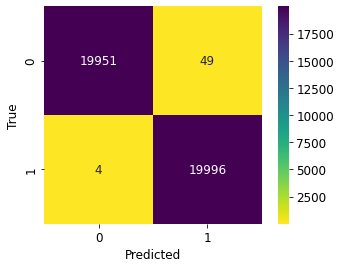

In [62]:
y_pred_test = model.predict(pool_test)

print_results(y_pred_test, y_test)

cm = confusion_matrix(y_test, y_pred_test)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');


It seems that model predicts very good

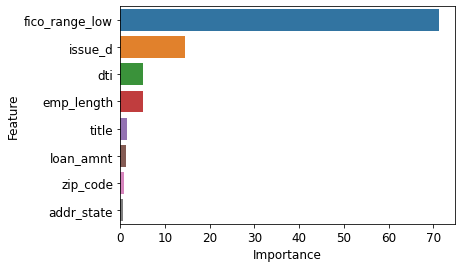

In [52]:
feat = model.feature_names_
imp = model.feature_importances_
data = pd.DataFrame({'Feature': feat, 'Importance': imp})
data = data.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=data);

In [27]:
X_test.tail(10)

,loan_amnt,issue_d,fico_range_low,dti,title,zip_code,addr_state,emp_length
33698,16000.0,2018-10-01,685.0,20.94,Credit card refinancing,970xx,OR,4 years
73043,15000.0,2018-08-11,628.0,22.95,Credit card refinancing,302xx,GA,< 1 year
114014,10000.0,2018-04-26,628.0,11.73,Debt consolidation,953xx,CA,< 1 year
12757,30000.0,2018-03-01,715.0,13.24,Home improvement,485xx,MI,10+ years
68042,10000.0,2018-05-01,670.0,30.24,Debt consolidation,800xx,CO,5 years
77298,28000.0,2018-03-01,710.0,10.52,Debt consolidation,604xx,IL,1 year
11587,25000.0,2018-05-14,628.0,19.51,Debt consolidation,606xx,IL,< 1 year
83468,3000.0,2018-11-13,628.0,11.82,Moving and relocation,282xx,NC,< 1 year
41979,3725.0,2018-06-29,628.0,2.40,Other,331xx,FL,< 1 year
24733,10000.0,2018-05-01,695.0,12.27,Debt consolidation,773xx,TX,5 years


In [54]:
from joblib import dump
dump(model, 'approveModel.joblib')

['approveModel.joblib']

# Data manipulation

Let's start looking at unique values

In [3]:
df = pd.read_csv("../input/lendingclub/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv", parse_dates=['issue_d'], infer_datetime_format=True)
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df.head())

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,2015-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,2015-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,N

In [4]:
df = df[(df.issue_d >= '2018-01-01 00:00:00') ]
df = df.sample(n=100000)

Let's look how many unique values has each column

In [11]:
num_feat = df.select_dtypes('number').columns.values
df[num_feat].nunique().sort_values().head(30)

member_id                              0
hardship_length                        1
deferral_term                          1
policy_code                            1
num_tl_120dpd_2m                       1
acc_now_delinq                         2
num_tl_30dpd                           2
chargeoff_within_12_mths               5
pub_rec_bankruptcies                   6
inq_last_6mths                         6
collections_12_mths_ex_med             6
sec_app_inq_last_6mths                 7
open_il_12m                            7
sec_app_collections_12_mths_ex_med     9
pub_rec                               10
sec_app_chargeoff_within_12_mths      10
tax_liens                             10
settlement_term                       12
open_acc_6m                           14
sec_app_mort_acc                      16
open_il_24m                           17
num_tl_90g_dpd_24m                    18
settlement_percentage                 20
delinq_2yrs                           20
open_rv_12m     

first 5 column has only one unique value, so no reason to have them still in dataset.

In [8]:
df = df.drop(['member_id', 'hardship_length', 'deferral_term','num_tl_120dpd_2m', 'policy_code'], axis=1, errors='ignore')

Same analyses for categorical columns

In [6]:
num_feat = df.select_dtypes('object').columns.values
df[num_feat].nunique().sort_values()

term                             2
debt_settlement_flag             2
disbursement_method              2
hardship_flag                    2
application_type                 2
pymnt_plan                       2
initial_list_status              2
hardship_status                  3
verification_status_joint        3
settlement_status                3
next_pymnt_d                     3
verification_status              3
hardship_loan_status             4
home_ownership                   4
grade                            7
loan_status                      7
hardship_start_date              8
hardship_reason                  8
debt_settlement_flag_date        9
payment_plan_start_date          9
hardship_end_date                9
emp_length                      11
settlement_date                 11
title                           12
purpose                         13
last_pymnt_d                    15
last_credit_pull_d              17
sub_grade                       35
addr_state          

Some categorical columns has just 1 or 100000 unique values, so I will drop those columns.

In [5]:
df = df.drop(['desc','hardship_type', 'id', 'url'], axis=1, errors='ignore')

# Filling missing data

In [9]:
df.shape

(100000, 142)

In [10]:
nan_mean = df.isna().mean()
nan_mean = nan_mean[nan_mean != 0].sort_values()
nan_mean.tail(60)

avg_cur_bal                                   0.00008
all_util                                      0.00029
revol_util                                    0.00111
last_pymnt_d                                  0.00116
dti                                           0.00229
mths_since_recent_bc                          0.01289
bc_open_to_buy                                0.01363
percent_bc_gt_75                              0.01364
bc_util                                       0.01406
mo_sin_old_il_acct                            0.03765
mths_since_rcnt_il                            0.03765
emp_length                                    0.08405
emp_title                                     0.11030
next_pymnt_d                                  0.11158
mths_since_recent_inq                         0.12307
il_util                                       0.16278
mths_since_last_delinq                        0.55672
mths_since_recent_revol_delinq                0.71072
mths_since_last_major_derog 

Percent of trades never delinquent
( percent of payments that were never late)

In [11]:
print('Median value = ' + str(df.pct_tl_nvr_dlq.median()))
median = df.pct_tl_nvr_dlq.median()
df.pct_tl_nvr_dlq = df.pct_tl_nvr_dlq.fillna(median)

Median value = 100.0


The median of this value is 100, so fill empty with median value

The most recent month LC pulled credit for this loan ( last_credit_pull_d)

In [12]:
print(df.last_credit_pull_d.value_counts())
df.last_credit_pull_d = df.last_credit_pull_d.fillna('Mar-2019')

Mar-2019    92674
Feb-2019     1706
Jan-2019     1426
Dec-2018      922
Nov-2018      752
Oct-2018      660
Sep-2018      454
Jul-2018      370
Aug-2018      369
May-2018      170
Apr-2018      125
Mar-2018      110
Feb-2018       97
Jun-2018       78
Jan-2018       70
Dec-2017       16
Apr-2019        1
Name: last_credit_pull_d, dtype: int64


It seems that last credit pull date is not set for some loans, fill empty with latest value Mar-2019.

Average current balance of all accounts (avg_cur_bal)
If empty - assume account balance is 0.

In [13]:
df.avg_cur_bal = df.avg_cur_bal.fillna(0.0)

Balance to credit limit on all trades (all_util)

In [14]:
print('Min value = ' + str(df.all_util.min()))
print('Median value = ' + str(df.all_util.median()))
df.all_util = df.all_util.fillna(0.0)

Min value = 0.0
Median value = 55.0


Because credit limit is null, let's assume it is 0.

Revolving line utilization rate, or the amount of credit the borrower is using relative to all available (revol_util)

In [15]:
print('Min value = ' + str(df.revol_util.min()))
print('Median value = ' + str(df.revol_util.median()))
df.revol_util = df.revol_util.fillna(0.0)

Min value = 0.0
Median value = 42.2


Then credit revolve is null, I assume nothing was used and set null to 0.

Last month payment was received (last_pymnt_d)

In [16]:
print(df.last_pymnt_d.value_counts())
df.last_pymnt_d = df.last_pymnt_d.fillna('Mar-2019')

Mar-2019    82499
Feb-2019     7125
Jan-2019     1817
Dec-2018     1365
Nov-2018     1291
Oct-2018     1262
Aug-2018     1003
Sep-2018      950
Jul-2018      768
Jun-2018      608
May-2018      417
Apr-2018      313
Mar-2018      249
Feb-2018      170
Jan-2018       47
Name: last_pymnt_d, dtype: int64


debt-to-income ratio (dti)
Assume that null are worst values, so fill null with dti max value.

In [17]:
print('Max value = ' + str(df.dti.max()))
print('Median value = ' + str(df.dti.median()))
df.dti = df.dti.fillna(df.dti.max())

Max value = 999.0
Median value = 17.67


Months since most recent bankcard account opened (mths_since_recent_bc).

Give value -1 as it never been opened.

In [18]:
print('Min value = ' + str(df.mths_since_recent_bc.min()))
print('Median value = ' + str(df.mths_since_recent_bc.median()))
df.mths_since_recent_bc = df.mths_since_recent_bc.fillna(-1.0)

Min value = 0.0
Median value = 15.0


Total open to buy on revolving bankcards (bc_open_to_buy).
Fill null with median

In [19]:
print('Min value = ' + str(df.bc_open_to_buy.min()))
print('Median value = ' + str(df.bc_open_to_buy.median()))
df.bc_open_to_buy = df.bc_open_to_buy.fillna(df.bc_open_to_buy.median())

Min value = 0.0
Median value = 8243.0


Percentage of all bankcard accounts > 75% of limit (percent_bc_gt_75).

Min value = 0.0
Median value = 25.0


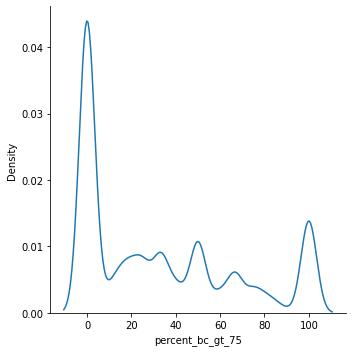

In [20]:
print('Min value = ' + str(df.percent_bc_gt_75.min()))
print('Median value = ' + str(df.percent_bc_gt_75.median()))
sns.displot(df, x="percent_bc_gt_75", kind="kde")
df.percent_bc_gt_75 = df.percent_bc_gt_75.fillna(0.0)

Ratio of total current balance to high credit/credit limit for all bankcard accounts (bc_util).

Min value = 0.0
Median value = 48.9


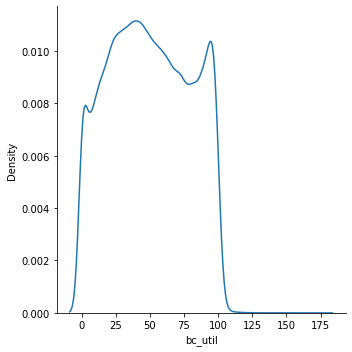

In [21]:
print('Min value = ' + str(df.bc_util.min()))
print('Median value = ' + str(df.bc_util.median()))
sns.displot(df, x="bc_util", kind="kde")
df.bc_util = df.bc_util.fillna(0.0)

Months since oldest bank installment account opened (mo_sin_old_il_acct).

Min value = 1.0
Median value = 130.0


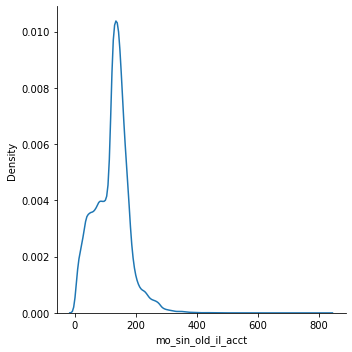

In [22]:
print('Min value = ' + str(df.mo_sin_old_il_acct.min()))
print('Median value = ' + str(df.mo_sin_old_il_acct.median()))
sns.displot(df, x="mo_sin_old_il_acct", kind="kde")
df.mo_sin_old_il_acct = df.mo_sin_old_il_acct.fillna(1.0)

Months since most recent installment accounts opened (mths_since_rcnt_il)

Min value = 0.0
Median value = 13.0


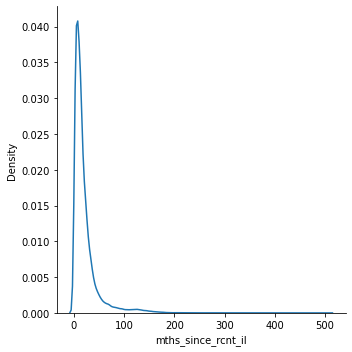

In [23]:
print('Min value = ' + str(df.mths_since_rcnt_il.min()))
print('Median value = ' + str(df.mths_since_rcnt_il.median()))
sns.displot(df, x="mths_since_rcnt_il", kind="kde")
df.mths_since_rcnt_il = df.mths_since_rcnt_il.fillna(0.0)

Employment length in years (emp_length).

In [24]:
print(df.emp_length.value_counts())
df.emp_length = df.emp_length.fillna('noInfo')

10+ years    32485
< 1 year      8956
2 years       8920
3 years       8195
1 year        6778
4 years       6329
5 years       6211
6 years       4405
7 years       3667
8 years       3178
9 years       2471
Name: emp_length, dtype: int64


The job title (emp_title)

In [25]:
print(df.emp_title.value_counts())
df.emp_title = df.emp_title.fillna('noInfo')

Teacher                                 1707
Manager                                 1630
Owner                                   1183
Driver                                   894
Registered Nurse                         745
                                        ... 
Rental Coordinator                         1
Assistant accountant                       1
Financial Trainer                          1
CT III                                     1
Senior Benefits Analyst- Project Mgr       1
Name: emp_title, Length: 35859, dtype: int64


Next payment day (next_pymnt_d).

In [26]:
print(df.next_pymnt_d.value_counts())
df.next_pymnt_d = df.next_pymnt_d.fillna('noInfo')

Apr-2019    88806
Mar-2019       22
May-2019       14
Name: next_pymnt_d, dtype: int64


Months since most recent inquiry (mths_since_recent_inq).
Fill null with median.

In [31]:
print('Min value = ' + str(df.mths_since_recent_inq.min()))
print('Median value = ' + str(df.mths_since_recent_inq.median()))
df.mths_since_recent_inq = df.mths_since_recent_inq.fillna(df.mths_since_recent_inq.median())

Min value = 0.0
Median value = 6.0


Ratio of total current balance to high credit/credit limit on all install account (il_util).
Fill null with median.

In [34]:
print('Min value = ' + str(df.il_util.min()))
print('Median value = ' + str(df.il_util.median()))
df.il_util = df.il_util.fillna(df.il_util.median())

Min value = 0.0
Median value = 71.0


The number of months since the borrower's last delinquency (mths_since_last_delinq).

In [37]:
print('Min value = ' + str(df.mths_since_last_delinq.min()))
print('Median value = ' + str(df.mths_since_last_delinq.median()))
df.mths_since_last_delinq = df.mths_since_last_delinq.fillna(0.0)

Min value = 0.0
Median value = 34.0


Months since most recent revolving delinquency (mths_since_recent_revol_delinq).

In [40]:
print('Min value = ' + str(df.mths_since_recent_revol_delinq.min()))
print('Median value = ' + str(df.mths_since_recent_revol_delinq.median()))
df.mths_since_recent_revol_delinq = df.mths_since_recent_revol_delinq.fillna(0.0)

Min value = 0.0
Median value = 35.0


Months since most recent 90-day or worse rating at time of application for the secondary applicant (mths_since_last_major_derog).

In [43]:
print('Min value = ' + str(df.mths_since_last_major_derog.min()))
print('Median value = ' + str(df.mths_since_last_major_derog.median()))
df.mths_since_last_major_derog = df.mths_since_last_major_derog.fillna(0.0)

Min value = 0.0
Median value = 47.0


Months since most recent bankcard delinquency (mths_since_recent_bc_dlq).

In [46]:
print('Min value = ' + str(df.mths_since_recent_bc_dlq.min()))
print('Median value = ' + str(df.mths_since_recent_bc_dlq.median()))
df.mths_since_recent_bc_dlq = df.mths_since_recent_bc_dlq.fillna(0.0)

Min value = 0.0
Median value = 39.0


Number of open trades at time of application for the secondary applicant (sec_app_open_acc).

In [49]:
print('Min value = ' + str(df.sec_app_open_acc.min()))
print('Median value = ' + str(df.sec_app_open_acc.median()))
df.sec_app_open_acc = df.sec_app_open_acc.fillna(-1.0)

Min value = 0.0
Median value = 10.0


Number of collections within last 12 months excluding medical collections at time of application for secondary applicant (sec_app_collections_12_mths_ex_med)

In [52]:
print('Min value = ' + str(df.sec_app_collections_12_mths_ex_med.min()))
print('Median value = ' + str(df.sec_app_collections_12_mths_ex_med.median()))
df.sec_app_collections_12_mths_ex_med = df.sec_app_collections_12_mths_ex_med.fillna(-1.0)

Min value = 0.0
Median value = 0.0


Number of charge-offs within last 12 months at time of application for the secondary applicant (sec_app_chargeoff_within_12_mths).

In [55]:
print('Min value = ' + str(df.sec_app_chargeoff_within_12_mths.min()))
print('Median value = ' + str(df.sec_app_chargeoff_within_12_mths.median()))
df.sec_app_chargeoff_within_12_mths = df.sec_app_chargeoff_within_12_mths.fillna(-1.0)

Min value = 0.0
Median value = 0.0


Number of currently active installment trades at time of application for the secondary applicant (sec_app_open_act_il).

In [58]:
print('Min value = ' + str(df.sec_app_open_act_il.min()))
print('Median value = ' + str(df.sec_app_open_act_il.median()))
df.sec_app_open_act_il = df.sec_app_open_act_il.fillna(-1.0)

Min value = 0.0
Median value = 2.0


Credit inquiries in the last 6 months at time of application for the secondary applicant (sec_app_inq_last_6mths).

In [62]:
print('Min value = ' + str(df.sec_app_inq_last_6mths.min()))
print('Median value = ' + str(df.sec_app_inq_last_6mths.median()))
df.sec_app_inq_last_6mths = df.sec_app_inq_last_6mths.fillna(-1.0)

Min value = 0.0
Median value = 0.0


The combined self-reported annual income provided by the co-borrowers during registration (annual_inc_joint).

In [65]:
print('Min value = ' + str(df.annual_inc_joint.min()))
print('Median value = ' + str(df.annual_inc_joint.median()))
df.annual_inc_joint = df.annual_inc_joint.fillna(-1.0)

Min value = 9000.0
Median value = 114000.0


A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations (dti_joint).

In [68]:
print('Min value = ' + str(df.dti_joint.min()))
print('Median value = ' + str(df.dti_joint.median()))
df.dti_joint = df.dti_joint.fillna(-1.0)

Min value = 0.0
Median value = 18.92


Fill null values for all columns related to secondary account -1.

In [75]:
df.revol_bal_joint = df.revol_bal_joint.fillna(-1.0)
df.sec_app_fico_range_low = df.sec_app_fico_range_low.fillna(-1.0)
df.sec_app_fico_range_high = df.sec_app_fico_range_high.fillna(-1.0)
df.sec_app_earliest_cr_line = df.sec_app_earliest_cr_line.fillna(-1.0)
df.sec_app_mort_acc = df.sec_app_mort_acc.fillna(-1.0)
df.sec_app_num_rev_accts = df.sec_app_num_rev_accts.fillna(-1.0)
df.sec_app_revol_util = df.sec_app_revol_util.fillna(-1.0)
df.verification_status_joint = df.verification_status_joint.fillna(-1.0)
df.sec_app_mths_since_last_major_derog = df.sec_app_mths_since_last_major_derog.fillna(-1.0)

Fill empty categorical data with 'null'

In [96]:
df.hardship_reason = df.hardship_reason.fillna('null')
df.hardship_status = df.hardship_status.fillna('null')
df.hardship_start_date = df.hardship_start_date.fillna('null')
df.hardship_end_date = df.hardship_end_date.fillna('null')
df.payment_plan_start_date = df.payment_plan_start_date.fillna('null')
df.hardship_loan_status = df.hardship_loan_status.fillna('null')
df.debt_settlement_flag_date = df.debt_settlement_flag_date.fillna('null')
df.settlement_status = df.settlement_status.fillna('null')
df.settlement_date = df.settlement_date.fillna('null')
df.payment_plan_start_date = df.payment_plan_start_date.fillna('null')
df.payment_plan_start_date = df.payment_plan_start_date.fillna('null')


Fill empty numeric values with -1.0

In [109]:
columns = df.columns[(df.isna().mean()>0)]

df[columns] = df[columns].fillna(-1.0)

# Summary

Succesfully all planned steps were reached.
- Created very good model which can approve or reject the loan.
- Created a model which can predict the grade for the loan
- Created a model which can predict the subgrade and the interest rate. 